# Identifying Humpback Whale Individuals by their Fluke Patterning

First, we pip-install any packages we will need beyond the usual:

In [1]:
# ! pip3 install kaggle --upgrade --user
# ! pip3 install pandas --user
# ! pip3 install seaborn --user
# ! pip3 install conx --upgrade
# ! pip3 install scikit-image

Before running the below command, go to Kaggle and sign in. If you get a 404 Error, go to the download data page for the competition and accept the terms of the agreement. 

https://www.kaggle.com/c/whale-categorization-playground/data

Now, we import everything that we will need:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import conx as cx
import os
import skimage as io

Using TensorFlow backend.
ConX, version 3.7.6


We set some global variables, including the path to download and install the images, and the size that we will use to make the images small, and consistent:

In [13]:
PROJECT_PATH = './'
try: 
    ann = pd.read_csv((PROJECT_PATH + 'train.csv'))
except FileNotFoundError: 
    print("The file was not found in the expected path. If you still need to download the data, \
carry out the download commands below. ")
ann.head()  

Image         Id
0  00022e1a.jpg  w_e15442c
1  000466c4.jpg  w_1287fbc
2  00087b01.jpg  w_da2efe0
3  001296d5.jpg  w_19e5482
4  0014cfdf.jpg  w_f22f3e3

In [18]:
cwd = os.getcwd()
print(cwd)

PROJECT_PATH = cwd + '/'
TRAIN_PATH = PROJECT_PATH + 'train/' 
RESIZE = (100,100) ## start out small

/Users/jacquelynzuker/Desktop/WhaleTailChallenge


If the PROJECT_PATH doesn't exist, we create it, and make the kaggle file have proper permissions:

In [168]:
# ! mkdir -p {PROJECT_PATH}
# ! chmod 600 ~/.kaggle/kaggle.json

Download the data to your working directory:

In [169]:
# ! kaggle competitions download -c whale-categorization-playground -p {PROJECT_PATH}
# ! unzip ~/Desktop/WhaleTailChallenge/test.zip

We use pandas to read the training data:

In [19]:
ann = pd.read_csv((PROJECT_PATH + 'train.csv'))

In [20]:
print('There are {} unique whales in the training set.'.format(len(ann.Id.unique())))
print('{0:.1f}% of the individuals are pictured only 1 time.'.format(
    (ann.Id.value_counts()==1).sum()/len(ann.Id.unique()) * 100))
print('{0:.1f} % of the photos are completely new whales.'.format(
    100 * len(ann.loc[ann['Id'] == 'new_whale']) / len(ann['Id'])))

There are 4251 unique whales in the training set.
52.2% of the individuals are pictured only 1 time.
8.2 % of the photos are completely new whales.


Let's look at the first image:

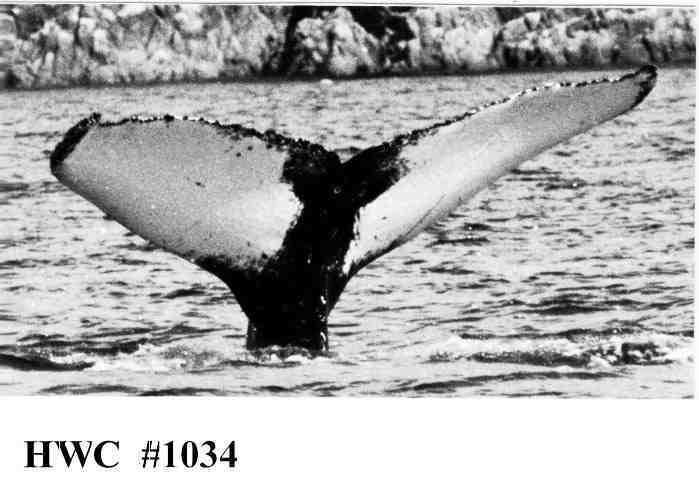

In [24]:
cx.image(PROJECT_PATH + "train/" + ann.Image[0])

Weird! It has a label in the image. This is not going to be an easy task with such dirty data. We could clean this up a bit with:

In [22]:
cx.image(PROJECT_PATH + "train/" + ann.Image[0]).size

(699, 500)

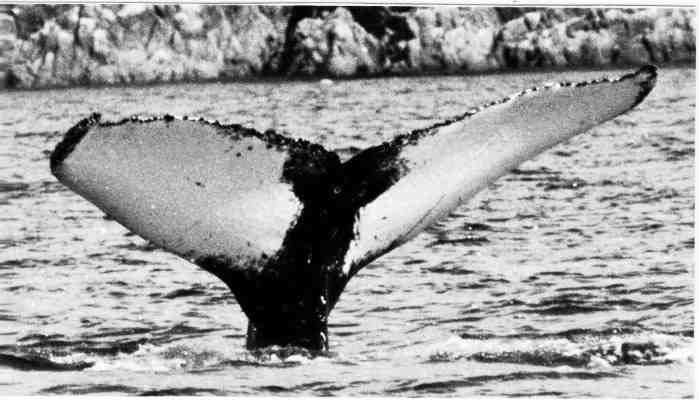

In [28]:
cx.crop_image(cx.image(PROJECT_PATH + "/train/" + ann.Image[0]), 0,0, 699,400)

For now, let's just look at some more images:

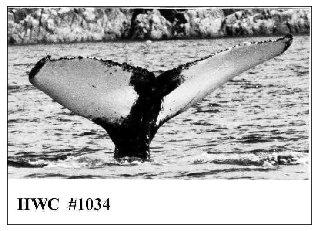

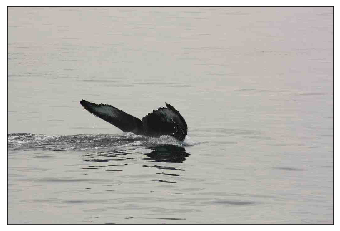

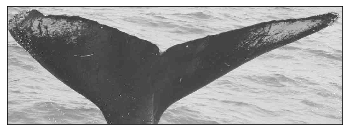

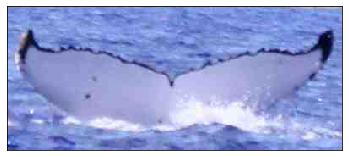

In [29]:
for i in range(4):
    cx.view(PROJECT_PATH + "/train/" + ann.Image[i])

### The most common whale:

In [30]:
print("The most common whale is {} with {} occurrences.".format(ann.Id.value_counts().index[1], ann.Id.value_counts()[1]))
matching_images = ann.loc[ann['Id']== ann.Id.value_counts().index[1], 'Image']


The most common whale is w_1287fbc with 34 occurrences.


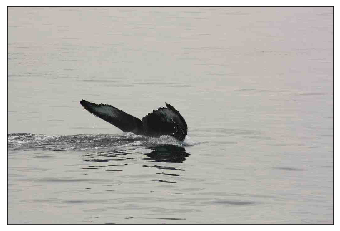

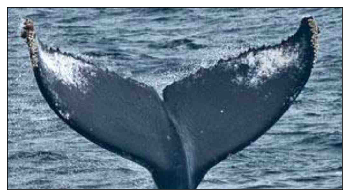

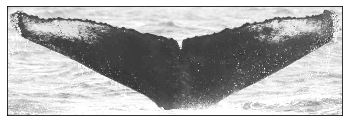

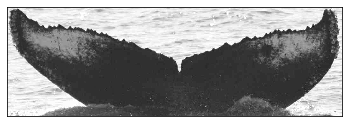

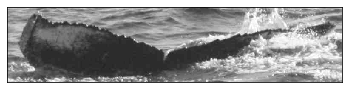

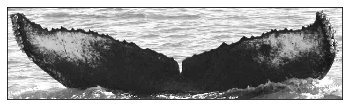

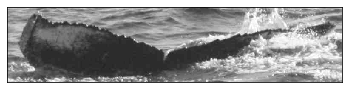

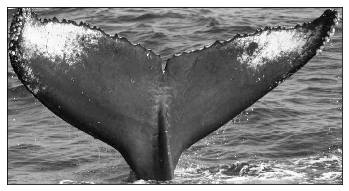

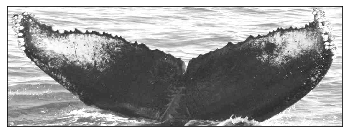

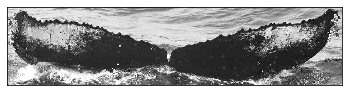

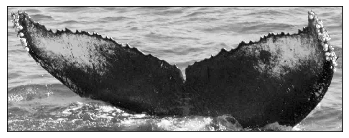

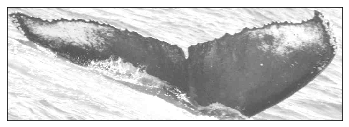

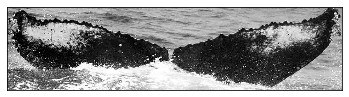

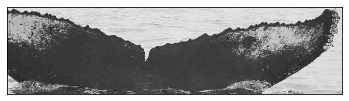

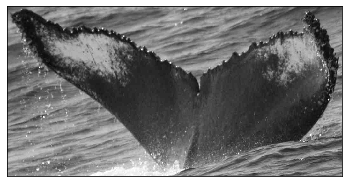

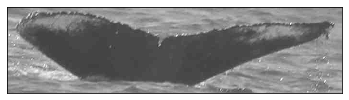

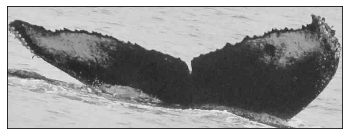

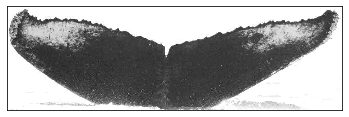

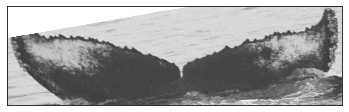

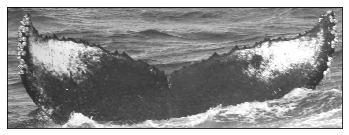

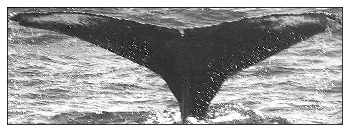

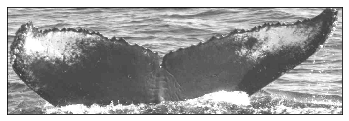

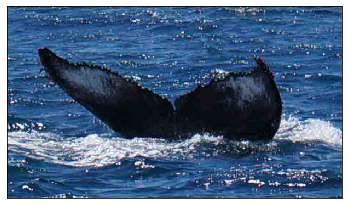

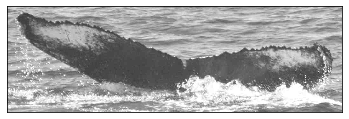

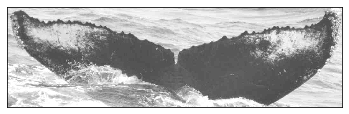

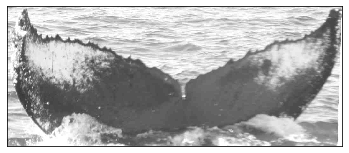

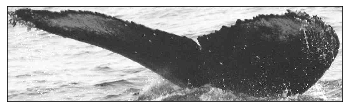

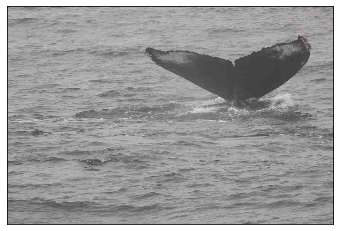

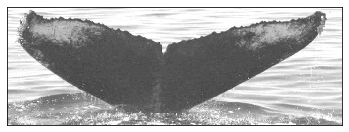

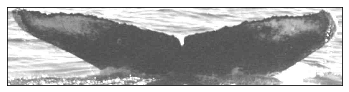

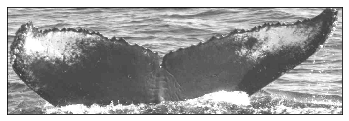

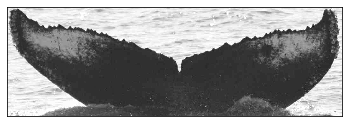

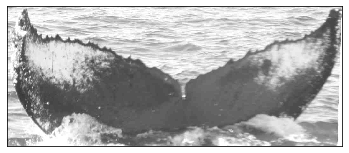

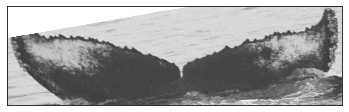

In [31]:
for filename in matching_images:
    cx.view(str(PROJECT_PATH) + 'train/' + (filename), labels = matching_images)

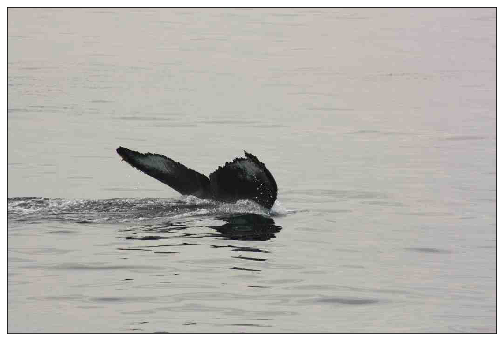

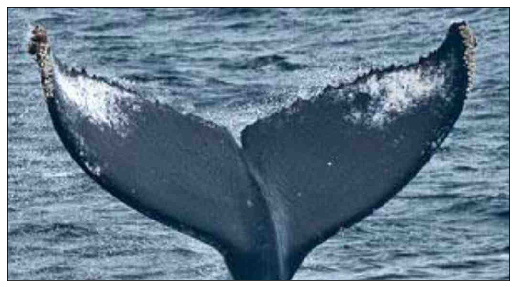

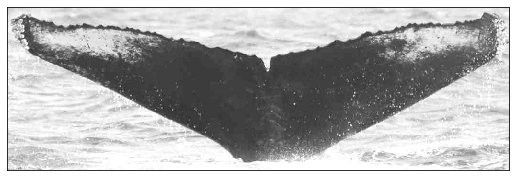

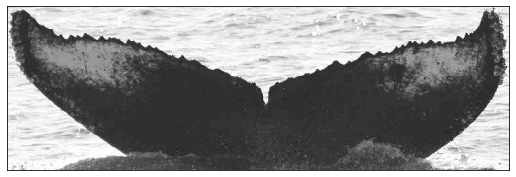

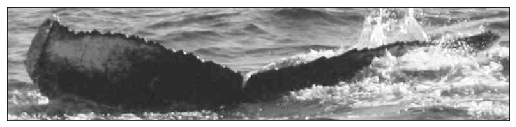

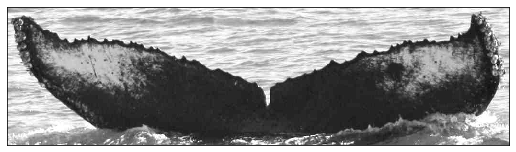

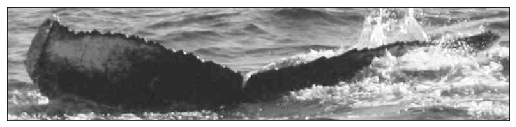

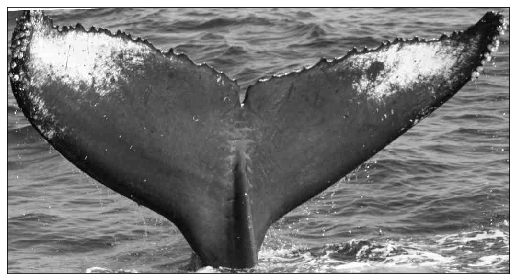

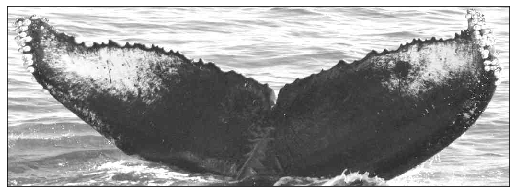

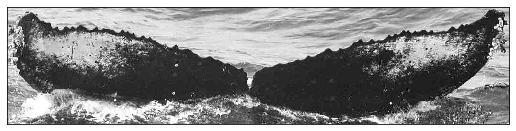

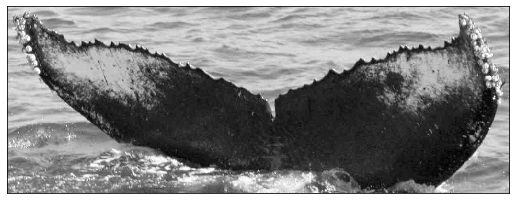

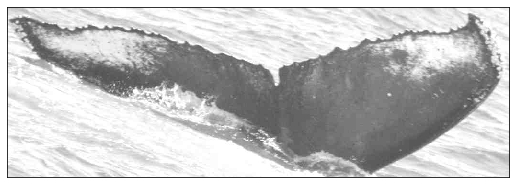

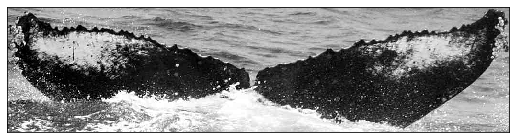

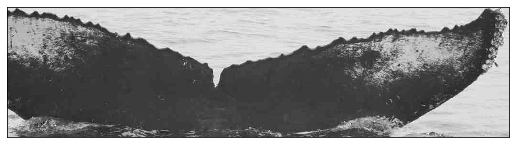

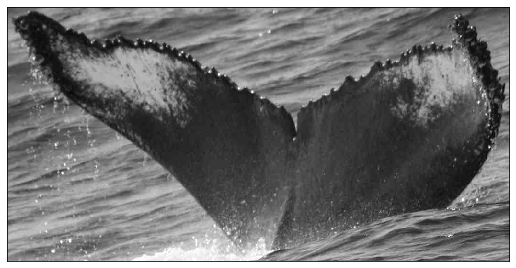

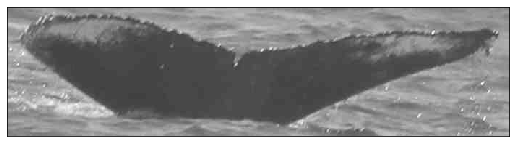

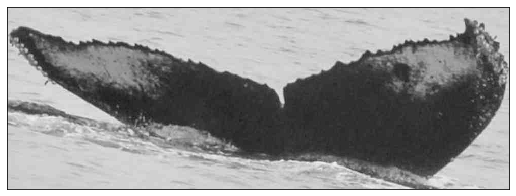

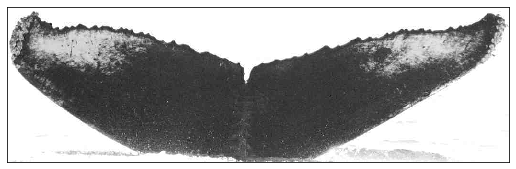

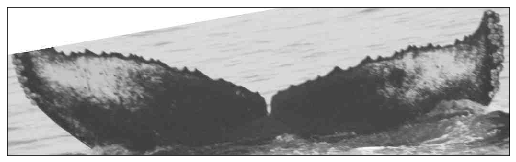

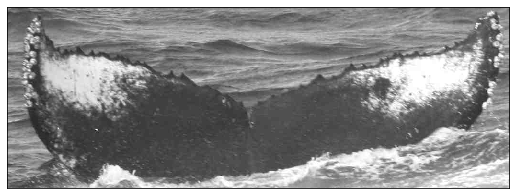

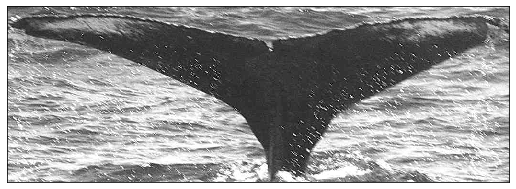

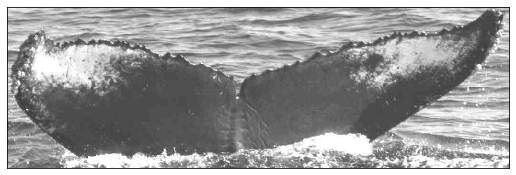

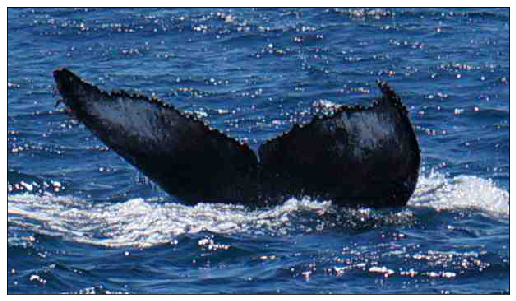

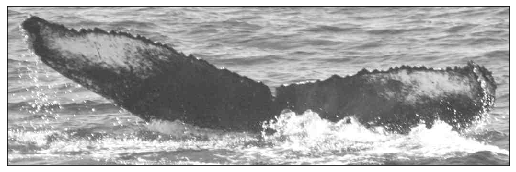

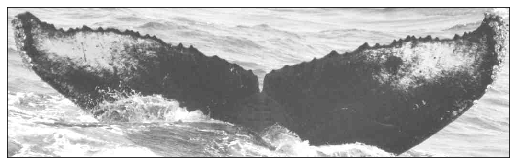

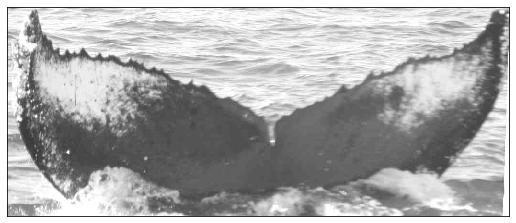

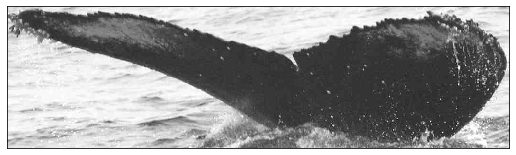

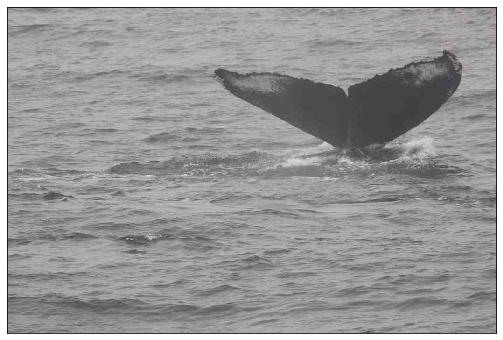

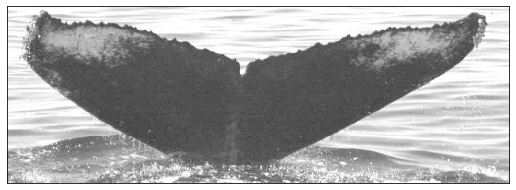

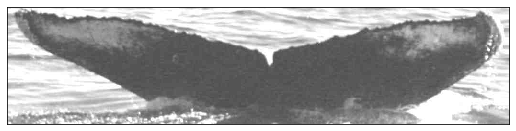

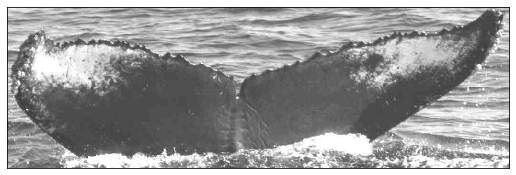

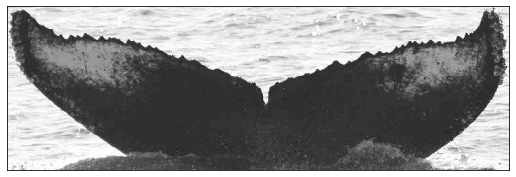

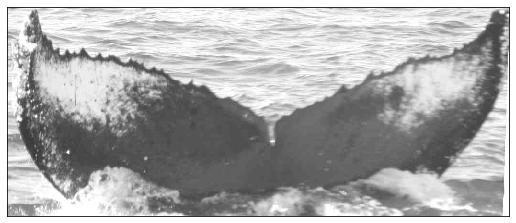

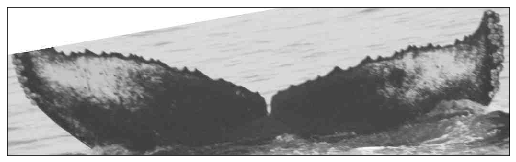

In [32]:
my_labels = ann.loc[ann['Image'].isin(matching_images.values), 'Id']
for filename in matching_images:
    cx.view((PROJECT_PATH) + 'train/' + (filename), labels=my_labels, scale=1.5)

Let's make the inputs for the network. For now, we'll make them (100,100) grayscale:

In [37]:
%%time
inputs = [cx.image_to_array(cx.image(f'{PROJECT_PATH}/train/{filename}', 
                                     gray=True, 
                                     resize=RESIZE))
          for filename in ann.Image[:10]]

CPU times: user 102 ms, sys: 4.47 ms, total: 106 ms
Wall time: 108 ms


In [39]:
cx.shape(inputs)

(10, 100, 100)

There are almost 10k images. Let's check that first one by turning it back into an image:

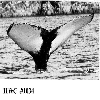

In [53]:
cx.array_to_image(inputs[0])

Looks good! Now, let's get the set of targets:

In [54]:
id_to_target = {id: index for (index, id) in enumerate(set(ann.Id))}

In [55]:
len(set(ann.Id))

4251

And make the targets:

In [56]:
targets = [cx.onehot(id_to_target[id],4251) for id in ann.Id]

In [57]:
cx.find_dimensions(4251)

[65, 66]

In [58]:
net = cx.Network("WhaleTail Network")
net.add(
    cx.Layer("input", RESIZE + (1,)), ## 3D
    cx.Conv2DLayer("conv1", 16, (5,5), activation="relu", dropout=0.20),
    cx.MaxPool2DLayer("maxpool1", (2,2)),
    cx.Conv2DLayer("conv2", 32, (5,5), activation="relu", dropout=0.20),
    cx.MaxPool2DLayer("maxpool2", (2,2)),
    cx.FlattenLayer("flatten"),
    cx.Layer("hidden", 100, activation='relu'),
    cx.Layer("output", 4251, vshape=(39, 109), activation='softmax'),
);
net.connect()

In [59]:
%%time
net.dataset.load(inputs=inputs, targets=targets)

CPU times: user 9.78 ms, sys: 659 µs, total: 10.4 ms
Wall time: 9.82 ms


In [75]:
len(inputs)


10

In [70]:
net.dataset.inputs.shape

[(100, 100)]

In [76]:
net.dataset.inputs.reshape(0, (100, 100, 1))

In [77]:
net.dataset.inputs.shape

[(100, 100, 1)]

In [78]:
net.compile(error="categorical_crossentropy", optimizer="rmsprop")

In [81]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, …

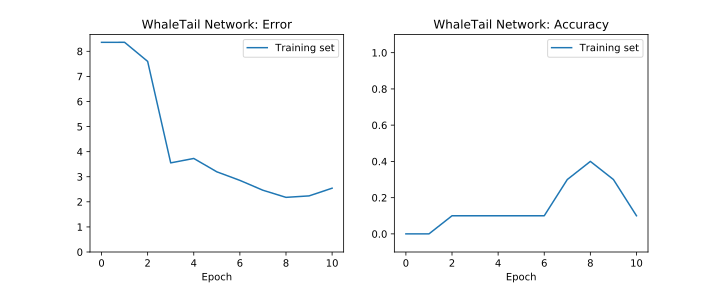

       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
#   10 |   2.54339 |   0.10000 


In [80]:
net.train(10)